In [1]:
import sys
sys.path.extend(['/Users/j4yzer/PycharmProjects/VKR'])
from utils.ml_data_provider import SectoralDataProvider


import lightgbm
import numpy as np
import pandas as pd

In [2]:

data_provider = SectoralDataProvider(cache_path='/Users/j4yzer/PycharmProjects/VKR/data/sectoral_ml')
data : pd.DataFrame = data_provider.load_data()

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', utc=False)

data = data.replace([-np.Inf, np.Inf], np.nan)
data = data.dropna()
data_by_sector = {sector: sector_data for sector, sector_data in data.groupby('sector')}
for sector, sector_data in data_by_sector.items():
    sector_data = sector_data.groupby("date").filter(lambda x: len(x) > 30)
    sector_data = sector_data[sector_data.groupby('ticker')['date'].transform('nunique') == sector_data['date'].nunique()]
    sector_data['nextPeriodRelativeToSectoralIndexReturn'] =  sector_data.groupby("date")["nextPeriodRelativeToSectoralIndexReturn"].rank("dense", ascending=True).astype(int)
    sector_data.rename(columns={'nextPeriodRelativeToSectoralIndexReturn': 'nextPeriodRank'}, inplace=True)
    sector_data['relativeToSectoralIndexReturn'] = sector_data.groupby('date')['relativeToSectoralIndexReturn'].rank('dense', ascending=True).astype(int)
    sector_data.rename(columns={'relativeToSectoralIndexReturn':'rank'}, inplace=True)
    data_by_sector[sector] = sector_data

In [3]:
def train_val_test_split(data, time_config = {'train_split_date': '2000-12-06',
               'val_split_date'  : '2014-02-10',
               'test_split_date' : '2018-02-20'}):

    train = data[(data.date >= time_config['train_split_date']) & (data.date < time_config['val_split_date'])]
    val = data[(data.date >= time_config['val_split_date']) & (data.date < time_config['test_split_date'])]
    test = data[(data.date >= time_config['test_split_date'])]
    return (train, val, test)

In [4]:
split_data_by_sector = {sector: train_val_test_split(sector_data.drop(['ticker', 'sector', 'sectoralIndex'], axis=1)) for sector, sector_data in data_by_sector.items()}
train_data_by_sector = {k: v[0] for k, v in split_data_by_sector.items()}
val_data_by_sector = {k: v[1] for k, v in split_data_by_sector.items()}
test_data_by_sector = {k: v[2] for k, v in split_data_by_sector.items()}
query_train_by_sector = {sector: [len(gs) for g_date, gs in sectoral_data.groupby('date')] for sector, sectoral_data in train_data_by_sector.items()}
query_val_by_sector = {sector: [len(gs) for g_date, gs in sectoral_data.groupby('date')] for sector, sectoral_data in val_data_by_sector.items()}
query_test_by_sector = {sector: [len(gs) for g_date, gs in sectoral_data.groupby('date')] for sector, sectoral_data in test_data_by_sector.items()}


In [5]:
from lightgbm import LGBMRanker
y_train_by_sector = {k: v['nextPeriodRank'] for k, v in train_data_by_sector.items()}
X_train_by_sector = {k: v.drop(
    ['nextPeriodRank', 'date', 'closePrice'], axis=1) for k, v in train_data_by_sector.items()}

[1]	valid_0's ndcg@1: 0.519022	valid_0's ndcg@2: 0.579611	valid_0's ndcg@3: 0.578948	valid_0's ndcg@4: 0.580514	valid_0's ndcg@5: 0.58584
[2]	valid_0's ndcg@1: 0.483696	valid_0's ndcg@2: 0.537625	valid_0's ndcg@3: 0.535846	valid_0's ndcg@4: 0.519762	valid_0's ndcg@5: 0.513811
[3]	valid_0's ndcg@1: 0.483696	valid_0's ndcg@2: 0.557768	valid_0's ndcg@3: 0.571167	valid_0's ndcg@4: 0.559229	valid_0's ndcg@5: 0.555395
[4]	valid_0's ndcg@1: 0.483696	valid_0's ndcg@2: 0.537625	valid_0's ndcg@3: 0.545247	valid_0's ndcg@4: 0.549668	valid_0's ndcg@5: 0.559553
[5]	valid_0's ndcg@1: 0.574728	valid_0's ndcg@2: 0.600275	valid_0's ndcg@3: 0.600407	valid_0's ndcg@4: 0.580946	valid_0's ndcg@5: 0.572393
[6]	valid_0's ndcg@1: 0.528533	valid_0's ndcg@2: 0.553688	valid_0's ndcg@3: 0.552457	valid_0's ndcg@4: 0.560869	valid_0's ndcg@5: 0.567892
[7]	valid_0's ndcg@1: 0.558424	valid_0's ndcg@2: 0.56051	valid_0's ndcg@3: 0.559019	valid_0's ndcg@4: 0.547868	valid_0's ndcg@5: 0.553736
[8]	valid_0's ndcg@1: 0.57608

KeyError: '0'

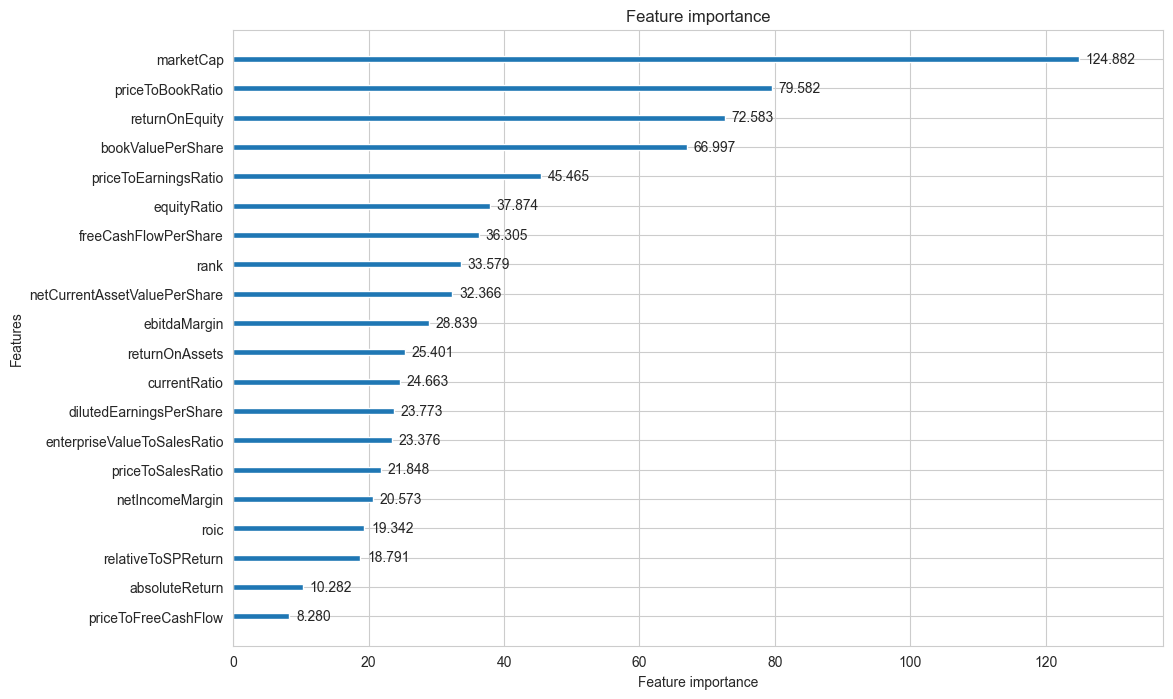

In [ ]:

from lightgbm import log_evaluation

y_val_by_sector = {k: v['nextPeriodRank'] for k, v in val_data_by_sector.items()}
X_val_by_sector = {k: v.drop(['nextPeriodRank', 'date', 'closePrice'], axis=1) for k, v in val_data_by_sector.items()}

y_test_by_sector = {k: v['nextPeriodRank'] for k, v in test_data_by_sector.items()}
X_test_by_sector = {k: v.drop(['nextPeriodRank', 'date', 'closePrice'], axis=1) for k, v in test_data_by_sector.items()}
model_return = LGBMRanker(objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 50,
                    importance_type = "gain",
                    metric= "ndcg",
                    num_leaves = 10,
                    learning_rate = 0.05,
                    max_depth = 7,
                    label_gain =[i for i in range(max(y_train_by_sector['Energy'].max(), y_val_by_sector['Energy'].max()) + 1)])
# For Energy sector
print(model_return.fit(X_train_by_sector['Energy'], y_train_by_sector['Energy'],
             group = query_train_by_sector['Energy'],
             callbacks=[log_evaluation(period=1)],
             eval_set=[(X_val_by_sector['Energy'], y_val_by_sector['Energy'])],
             eval_group=[query_val_by_sector['Energy']]
                       ))
lightgbm.plot_importance(model_return, figsize = (12,8))
test_pred = model_return.predict(X_train_by_sector['Energy'].head(query_train_by_sector['Energy'][0]))
preds = pd.Series(test_pred).rank(method='dense', ascending=True).astype(int)
actuals = y_test_by_sector['Energy'].head(query_test_by_sector['Energy'][0]).reset_index()['nextPeriodRank']
print(preds['0'] - actuals['nextPeriodRank'])

# CatBoost approach